## FILTRADO SEÑAL - CREACIÓN EPOCHS - APLICACIÓN FFT

 - El dataframe contiene los 4 canales, con 2560 registros para cada imagen y canal, 10 segundos.
 - Primero aplicaré un filtro butter tipo bandpass entre 1 y 49 Hz.
 - Después separaré los datos para cada imagen
 - Crearé los epochs o ventanas temporales en cada imagen: 9 ventanas de 2 segundos con un overlap de 1 segundo (512 samples por ventana con un overlap de 254 samples).
 - Por último, aplicar la FFT con 8 bins
 - Al final del proceso debería tener por cada imagen 1 row con 288 columnas: 4 canales x 9 ventanas x 8 bins
 - Dataset final: 730 imágenes (rows) x 288 features (columnas)

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, lfilter
from scipy.fftpack import fft, ifft
from skimage import util
% matplotlib inline

In [5]:
registro = pd.read_csv('pics_eeg.csv')
cols = ['image','timestamps','AF7','AF8','TP9','TP10']
registro = registro[cols]

In [7]:
# Aplicar bandpass filter entre 1 y 49 Hz  --> en todos las row de los 4 canales

def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

In [8]:
registro['af7_filter'] = butter_bandpass_filter(registro.AF7, 1,49, 256)
registro['af8_filter'] = butter_bandpass_filter(registro.AF8, 1,49, 256)
registro['tp9_filter'] = butter_bandpass_filter(registro.TP9, 1,49, 256)
registro['tp10_filter'] = butter_bandpass_filter(registro.TP10, 1,49, 256)

In [9]:
registro_filtrado = registro[['image','timestamps','af7_filter','af8_filter','tp9_filter','tp10_filter']]

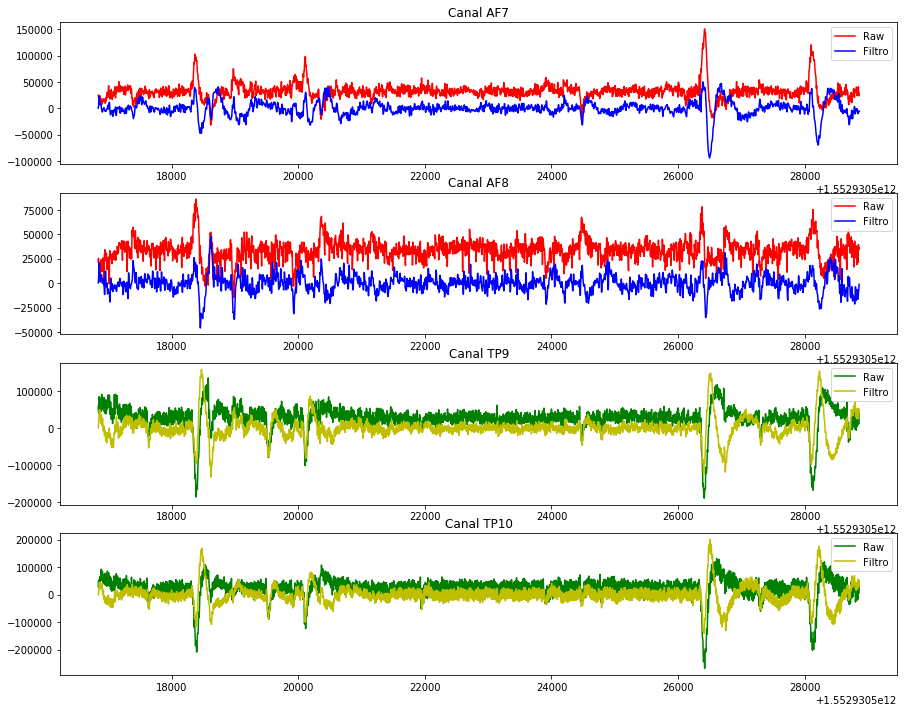

In [10]:
# Ejemplo para una única imagen: Con filtro vs. sin filtro

df_example = registro.loc[registro['image'] == 'Sp063.bmp']

f, axs = plt.subplots(4,1,figsize=(15,12))
plt.subplot(4, 1, 1)
plt.plot(df_example.timestamps, df_example.AF7, color='r', label = 'Raw')
plt.legend(loc="upper right")
plt.plot(df_example.timestamps, df_example.af7_filter, color='b', label = 'Filtro')
plt.legend(loc="upper right")
plt.title('Canal AF7')
plt.subplot(4, 1, 2)
plt.plot(df_example.timestamps, df_example.AF8, color='r', label = 'Raw')
plt.legend(loc="upper right")
plt.plot(df_example.timestamps, df_example.af8_filter, color='b', label = 'Filtro')
plt.legend(loc="upper right")
plt.title('Canal AF8')
plt.subplot(4, 1, 3)
plt.plot(df_example.timestamps, df_example.TP9, color='g', label = 'Raw')
plt.legend(loc="upper right")
plt.plot(df_example.timestamps, df_example.tp9_filter, color='y', label = 'Filtro')
plt.legend(loc="upper right")
plt.title('Canal TP9')
plt.subplot(4, 1, 4)
plt.plot(df_example.timestamps, df_example.TP10, color='g', label = 'Raw')
plt.legend(loc="upper right")
plt.plot(df_example.timestamps, df_example.tp10_filter, color='y', label = 'Filtro')
plt.legend(loc="upper right")
plt.title('Canal TP10')
plt.show()

In [11]:
# Separo el dataframe para cada imagen.
# Creo un diccionario donde la key es la imagen y el value es el dataframe con los valores
# quito 1s y algo al final

images = list(registro_filtrado.image.unique())
cols = ['af7_filter','af8_filter','tp9_filter','tp10_filter']
pictures = []
for pic in images:
    pic = pic.replace('.bmp','')
    pictures.append(pic)

dict_pictures = {}
for pic in images:
    dict_pictures[pic] = (((registro_filtrado[(registro_filtrado['image'] == pic)])[10:2571]).reset_index()).drop(['image','index'], axis = 1)

In [12]:
# Crear los epochs para cada imagen --> separar por imagen, despues aplicar epochs 2s y 2s overlap

def epochs(sample):
    epochs = util.view_as_windows(sample, window_shape=(512,), step=256)
    win = np.hanning(512 + 1)[:-1]
    epochs = epochs * win
    df_epochs = (pd.DataFrame(epochs.T))
    df_epochs.columns = ['Win_1','Win_2','Win_3','Win_4','Win_5','Win_6','Win_7','Win_8','Win_9']
    return df_epochs

In [13]:
# Tengo un nuevo diccionario donde cada keys es: 'imagen:canal', y el value son las 9 ventanas temporales

cols = ['af7_filter','af8_filter','tp9_filter','tp10_filter']

dict_pic_epoch = {}

for pic in images:
    for col in cols:
        sample = ((dict_pictures[pic])[col]).values
        dict_pic_epoch[pic+": "+col] = epochs(sample)

In [14]:
# Funcion FFT

def fft_win (to_fft, n, fs):
    win_fft = np.abs(np.fft.fft(to_fft, n=n)[:fs // 2])
    return win_fft

In [16]:
# Aplicar la DFT a cada una de las ventanas:
# creo un diccionario que tiene keys tipo: 'Sp063.bmp: af7_filter: Win_1', en la que los values son 8 bins FFT

todas_keys = list(dict_pic_epoch.keys())  # lista de todas las keys del diccionario
windows = ['Win_1','Win_2','Win_3','Win_4','Win_5','Win_6','Win_7','Win_8','Win_9']
n = 8                                     # numero de bins
fs = 256                                  # frecuency sampling
data_fft_dict = {}

for key in todas_keys:
    for win in windows:
        to_fft = ((dict_pic_epoch[key])[win]).values
        data_fft_dict[key+": "+win] = fft_win(to_fft, 8, 256)          

In [17]:
# Pasar el diccionario a dataframe

data_fft = pd.DataFrame.from_dict(data_fft_dict).T

In [18]:
# Creación de las columnas del dataset final

name_columns = []
chanels = ['AF7','AF8','TP9','TP10']
windows = ['W1','W2','W3','W4','W5','W6','W7','W8','W9']
fft_bins = ['bin1','bin2','bin3','bin4','bin5','bin6','bin7','bin8']

for chanel in chanels:
    for window in windows:
        for bins in fft_bins:
            name_columns.append(('{}'+'-'+'{}'+'-'+'{}').format(chanel, window, bins))
            

In [19]:
# Crear el dataframe con la forma final = nºimagenes x 288 columnas

df_image = pd.DataFrame (data=None, index = pictures, columns=name_columns)

In [20]:
# Bucles para colocar bien las filas y columnas

images_cols = []
images_e = []

for i in range(len(pictures)):
    images_cols.append(np.array(data_fft.iloc[i*36:(i+1)*36]))
    
for j in range(len(images_cols)): 
    for array in images_cols[j]:
        for e in array:
            images_e.append(e)
            
for i in range(len(pictures)):
    df_image.iloc[i] = images_e[i*288:(i+1)*288]

In [22]:
# Convertir el index en la columna 'pictures'

df_image['pictures'] = df_image.index

df_image.to_csv('pics_eeg_process.csv', index= False)